## Latent Diffusion model Text-to-image synthesis, trained on the LAION-400M dataset
### [Latent Diffusion](https://github.com/CompVis/latent-diffusion) and training the model by CompVis and the [LAION-400M dataset](https://laion.ai/laion-400-open-dataset/) by LAION.

##### Colab assembled by loboere https://github.com/loboere/latent-diffusion-inpainting-colab

## Save model and outputs on Google Drive? 

In [ ]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}
#@markdown Enable saving models to Google Drive to avoid downloading the 6GB model every Colab instance
save_models_to_google_drive = True #@param {type:"boolean"}

if save_outputs_to_google_drive or save_models_to_google_drive:
    from google.colab import drive
    try:
      drive.mount('/content/gdrive')
    except:
      save_outputs_to_google_drive = False
      save_models_to_google_drive = False

model_path = "/content/gdrive/MyDrive/AI/models" if save_models_to_google_drive else "/models/ldm/text2img-large"
outputs_path = "/content/gdrive/MyDrive/AI/Latent_Diffusion" if save_outputs_to_google_drive else "/content/outputs"
!mkdir -p $model_path
!mkdir -p $outputs_path
print(f"Model will be stored at {model_path}")
print(f"Outputs will be saved to {outputs_path}")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model will be stored at /content/gdrive/MyDrive/AI/models
Outputs will be saved to /content/gdrive/MyDrive/AI/Latent_Diffusion


# Setup stuff (this lasts a few minutes!)

In [ ]:
!git clone https://github.com/loboere/latent-diffusion-inpainting-colab.git

Cloning into 'latent-diffusion-inpainting-colab'...
remote: Enumerating objects: 371, done.
remote: Total 371 (delta 0), reused 0 (delta 0), pack-reused 371
Receiving objects: 100% (371/371), 39.03 MiB | 10.42 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [ ]:
%cd /content/latent-diffusion-inpainting-colab

/content/latent-diffusion-inpainting-colab


In [ ]:
#@title Installation

#!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 
!pip install pytorch-lightning==1.7.7 
!pip install torch-fidelity 
!pip install einops
!pip install transformers
!pip install open_clip_torch
!pip install autokeras
!pip install tensorflow
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/latent-diffusion-inpainting-colab/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Can't uninstall 'taming-transformers'. No files were found to uninstall.
  Running setup.py develop for taming-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://u

Now, download the checkpoint (~5.7 GB). This will usually take 3-6 minutes.

In [ ]:
model_path

'/models/ldm/text2img-large'

In [ ]:
!mkdir ./models/ldm/text2img-large

In [ ]:
#@title Download model
%cd /content/latent-diffusion-inpainting-colab

import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using saved model from Google Drive")
else: 
    %cd ./models/ldm/text2img-large 
    !wget https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt
    %cd /content/latent-diffusion-inpainting-colab

/content/latent-diffusion-inpainting-colab
/content/latent-diffusion-inpainting-colab/models/ldm/text2img-large
--2023-04-25 07:33:06--  https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6152314307 (5.7G)
Saving to: ‘model.ckpt’

model.ckpt           73%[=============>      ]   4.24G  14.3MB/s    in 5m 5s   

2023-04-25 07:38:11 (14.2 MB/s) - Connection closed at byte 4551917568. Retrying.

--2023-04-25 07:38:12--  (try: 2)  https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 6152314307 (5.7G), 1600396739 (1.5G) remaining
Saving to: ‘model.ckpt’

model.ckpt          100%[++++++++++++++=====>]   5.73G  13.0

Let's also check what type of GPU we've got.

In [ ]:
!nvidia-smi

Tue Apr 25 07:40:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load it.

In [ ]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config

In [ ]:
%cd /content/latent-diffusion-inpainting-colab

/content/latent-diffusion-inpainting-colab


In [ ]:
#@title Import stuff
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm.auto import tqdm, trange
tqdm_auto_model = __import__("tqdm.auto", fromlist=[None]) 
sys.modules['tqdm'] = tqdm_auto_model
from einops import rearrange
from torchvision.utils import make_grid
import transformers
import gc
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from open_clip import tokenizer
import open_clip
import tensorflow as tf

In [ ]:
#@title Load necessary functions 
def preprocess_image(image_path):
    image = Image.open(image_path)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    image = np.array(image).astype(np.uint8)
    image = (image/127.5 - 1.0).astype(np.float32)
    return image

def preprocess_mask(mask_path, h, w):
    mask = Image.open(mask_path).convert('1')
    mask_resize = mask.resize((w, h))
    return np.array(mask_resize).astype(np.float32)

def load_safety_model(clip_model):
    """load the safety model"""
    import autokeras as ak  # pylint: disable=import-outside-toplevel
    from tensorflow.keras.models import load_model  # pylint: disable=import-outside-toplevel
    from os.path import expanduser  # pylint: disable=import-outside-toplevel

    home = expanduser("~")

    cache_folder = home + "/.cache/clip_retrieval/" + clip_model.replace("/", "_")
    if clip_model == "ViT-L/14":
        model_dir = cache_folder + "/clip_autokeras_binary_nsfw"
        dim = 768
    elif clip_model == "ViT-B/32":
        model_dir = cache_folder + "/clip_autokeras_nsfw_b32"
        dim = 512
    else:
        raise ValueError("Unknown clip model")
    if not os.path.exists(model_dir):
        os.makedirs(cache_folder, exist_ok=True)

        from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel

        path_to_zip_file = cache_folder + "/clip_autokeras_binary_nsfw.zip"
        if clip_model == "ViT-L/14":
            url_model = "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_binary_nsfw.zip"
        elif clip_model == "ViT-B/32":
            url_model = (
                "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_nsfw_b32.zip"
            )
        else:
            raise ValueError("Unknown model {}".format(clip_model))
        urlretrieve(url_model, path_to_zip_file)
        import zipfile  # pylint: disable=import-outside-toplevel

        with zipfile.ZipFile(path_to_zip_file, "r") as zip_ref:
            zip_ref.extractall(cache_folder)

    loaded_model = load_model(model_dir, custom_objects=ak.CUSTOM_OBJECTS)
    loaded_model.predict(np.random.rand(10 ** 3, dim).astype("float32"), batch_size=10 ** 3)

    return loaded_model

def is_unsafe(safety_model, embeddings, threshold=0.5):
    """find unsafe embeddings"""
    nsfw_values = safety_model.predict(embeddings, batch_size=embeddings.shape[0])
    x = np.array([e[0] for e in nsfw_values])
    #print(x)
    return True if x > threshold else False
#NSFW CLIP Filter
safety_model = load_safety_model("ViT-B/32")
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().cuda()
    model.eval()
    return model

config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml") 
model = load_model_from_config(config, f"/content/latent-diffusion-inpainting-colab{model_path}/model.ckpt")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)


1/1 [==============================] - 3s 3s/step
Loading model from /content/latent-diffusion-inpainting-colab/models/ldm/text2img-large/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 872.30 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [ ]:

#@title definir run
def run(opt):
    torch.cuda.empty_cache()
    gc.collect()
    if opt.plms:
        opt.ddim_eta = 0
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)
    
    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    prompt = opt.prompt


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))


    image_prompt = opt.image_prompt
    mask_prompt = opt.mask_prompt

    # by default not do inpaint
    x0 = None
    mask = None

    # inpaint
    if image_prompt and mask_prompt:
        print("Using image as x0: " + image_prompt)
        print("Using mask image: " + mask_prompt)
        image_prompt_input = preprocess_image(image_prompt)
        image_prompt_input = rearrange(image_prompt_input, 'h w c -> c h w')
        image_prompt_input = torch.from_numpy(image_prompt_input)
        image_prompt_input = image_prompt_input.to(memory_format=torch.contiguous_format).to(torch.float16)
        image_prompt_input = repeat(image_prompt_input, 'c h w -> b c h w', b=opt.n_samples) 
        image_prompt_input = image_prompt_input.to(device)
        #print(image_prompt_input)
        encoder_posterior = model.encode_first_stage(image_prompt_input )
        x0 = model.get_first_stage_encoding(encoder_posterior).detach()
        h = opt.H//8
        w = opt.W//8
        mask_prompt_input = preprocess_mask(mask_prompt, h, w)
        mask = torch.tensor(mask_prompt_input)
        mask = repeat(mask, 'h w -> b h w', b=opt.n_samples).to(device)
        mask = mask[:, None, ...]



    all_samples=list()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            with model.ema_scope():
                uc = None
                if opt.scale > 0:
                    uc = model.get_learned_conditioning(opt.n_samples * [""])
                for n in trange(opt.n_iter, desc="Sampling"):
                    c = model.get_learned_conditioning(opt.n_samples * [prompt])
                    shape = [4, opt.H//8, opt.W//8]
                    if image_prompt and mask_prompt:
                       samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                    conditioning=c,
                                                    batch_size=opt.n_samples,
                                                    shape=shape,
                                                    verbose=False,
                                                    unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,
                                                    x0=x0,
                                                    mask=mask,
                                                    eta=opt.ddim_eta)
                    else:
                       samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                    conditioning=c,
                                                    batch_size=opt.n_samples,
                                                    shape=shape,
                                                    verbose=False,
                                                    unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,
                                                    eta=opt.ddim_eta)
                    x_samples_ddim = model.decode_first_stage(samples_ddim)
                    x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)

                    for x_sample in x_samples_ddim:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image_vector = Image.fromarray(x_sample.astype(np.uint8))
                        image = preprocess(image_vector).unsqueeze(0)
                        with torch.no_grad():
                          image_features = clip_model.encode_image(image)
                        image_features /= image_features.norm(dim=-1, keepdim=True)
                        query = image_features.cpu().detach().numpy().astype("float32")
                        unsafe = is_unsafe(safety_model,query,opt.nsfw_threshold)
                        image_vector.save(os.path.join(sample_path, f"{base_count:04}.png"))
                        #if(not unsafe):
                        #  image_vector.save(os.path.join(sample_path, f"{base_count:04}.png"))
                        #else:
                        #  raise Exception('Potential NSFW content was detected on your outputs. Try again with different prompts. If you feel your prompt was not supposed to give NSFW outputs, this may be due to a bias in the model')
                        base_count += 1
                    all_samples.append(x_samples_ddim)


    # additionally, save as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=opt.n_samples)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    
    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{prompt.replace(" ", "-")}.png'))
    display(Image.fromarray(grid.astype(np.uint8)))
    #print(f"Your samples are ready and waiting four you here: \n{outpath} \nEnjoy.")

# Do the run

### Biases acknowledgment
Despite how impressive being able to turn text into image is, beware to the fact that this model may output content that reinforces or exarcbates societal biases. According to the <a href='https://arxiv.org/abs/2112.10752' target='_blank'>Latent Diffusion paper</a>:<i> \"Deep learning modules tend to reproduce or exacerbate biases that are already present in the data\"</i>. 

The model was trained on an unfiltered version the LAION-400M dataset, which scrapped non-curated image-text-pairs from the internet (the exception being the the removal of illegal content) and is meant to be used for research purposes, such as this one. <a href='https://laion.ai/laion-400-open-dataset/' target='_blank'>You can read more on LAION's website</a>

Using image as x0: /content/latent-diffusion-inpainting-colab/test/a.jpg
Using mask image: /content/latent-diffusion-inpainting-colab/test/a_mask2.jpg


Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


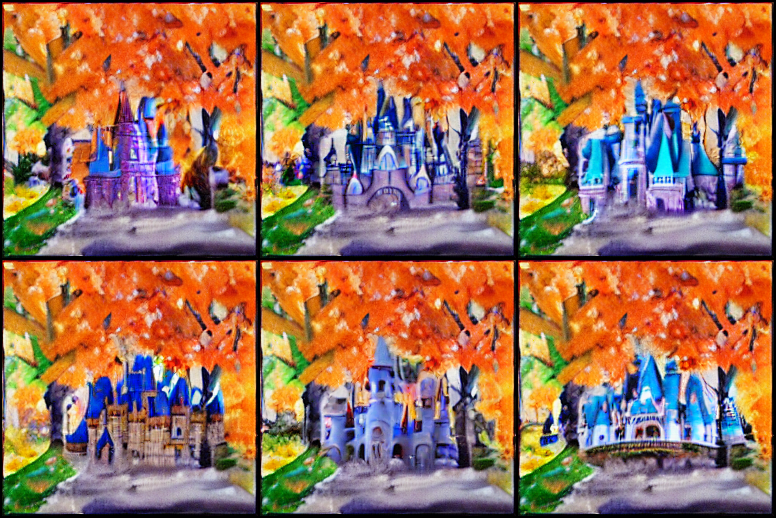

In [ ]:
#@title Parameters
import argparse
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange, repeat
from torchvision.utils import make_grid

Prompt = "disney castle" #@param{type:"string"}
Steps = 50 #@param {type:"integer"}
ETA = 0 #@param{type:"integer"}
Iterations =  2#@param{type:"integer"}
Width=256 #@param{type:"integer"}
Height=256 #@param{type:"integer"}
Samples_in_parallel=3 #@param{type:"integer"}
Diversity_scale=5.0 #@param {type:"number"}
PLMS_sampling=True #@param {type:"boolean"}
nsfw_threshold=100 #@param {type:"number"}  
img_path= "/content/latent-diffusion-inpainting-colab/test/a.jpg" #@param{type:"string"}
mask_path= "/content/latent-diffusion-inpainting-colab/test/a_mask2.jpg" #@param{type:"string"}

args = argparse.Namespace(
    prompt = Prompt, 
    outdir=f'{outputs_path}',
    ddim_steps = Steps,
    ddim_eta = ETA,
    n_iter = Iterations,
    W=Width,
    H=Height,
    n_samples=Samples_in_parallel,
    scale=Diversity_scale,
    plms=PLMS_sampling,
    nsfw_threshold=nsfw_threshold,
    image_prompt=img_path,
    mask_prompt=mask_path
)
run(args)

Using image as x0: /content/latent-diffusion-inpainting-colab/test/b.jpg
Using mask image: /content/latent-diffusion-inpainting-colab/test/b_mask2.jpg


Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


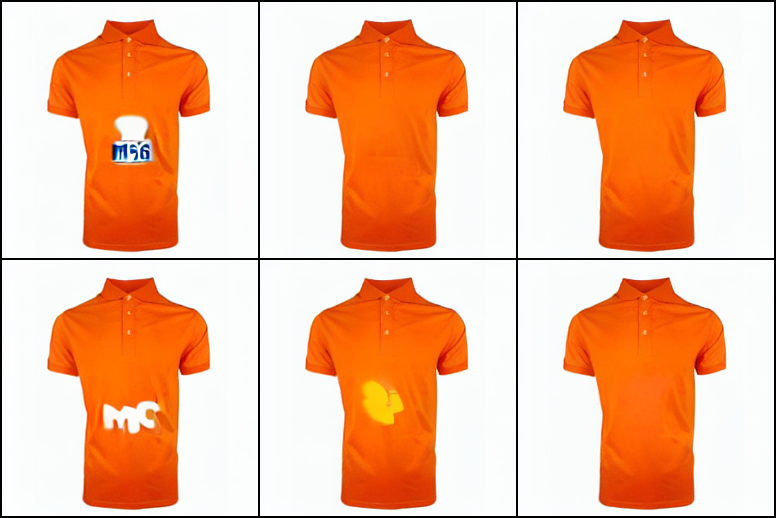

In [ ]:
#@title Parameters
import argparse
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange, repeat
from torchvision.utils import make_grid

Prompt = "MSG" #@param{type:"string"}
Steps = 50 #@param {type:"integer"}
ETA = 0 #@param{type:"integer"}
Iterations =  2#@param{type:"integer"}
Width=256 #@param{type:"integer"}
Height=256 #@param{type:"integer"}
Samples_in_parallel=3 #@param{type:"integer"}
Diversity_scale=5.0 #@param {type:"number"}
PLMS_sampling=True #@param {type:"boolean"}
nsfw_threshold=100 #@param {type:"number"}  
img_path= "/content/latent-diffusion-inpainting-colab/test/b.jpg" #@param{type:"string"}
mask_path= "/content/latent-diffusion-inpainting-colab/test/b_mask2.jpg" #@param{type:"string"}

args = argparse.Namespace(
    prompt = Prompt, 
    outdir=f'{outputs_path}',
    ddim_steps = Steps,
    ddim_eta = ETA,
    n_iter = Iterations,
    W=Width,
    H=Height,
    n_samples=Samples_in_parallel,
    scale=Diversity_scale,
    plms=PLMS_sampling,
    nsfw_threshold=nsfw_threshold,
    image_prompt=img_path,
    mask_prompt=mask_path
)
run(args)

Using image as x0: /content/latent-diffusion-inpainting-colab/test/c.jpg
Using mask image: /content/latent-diffusion-inpainting-colab/test/c_mask2.jpg


Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


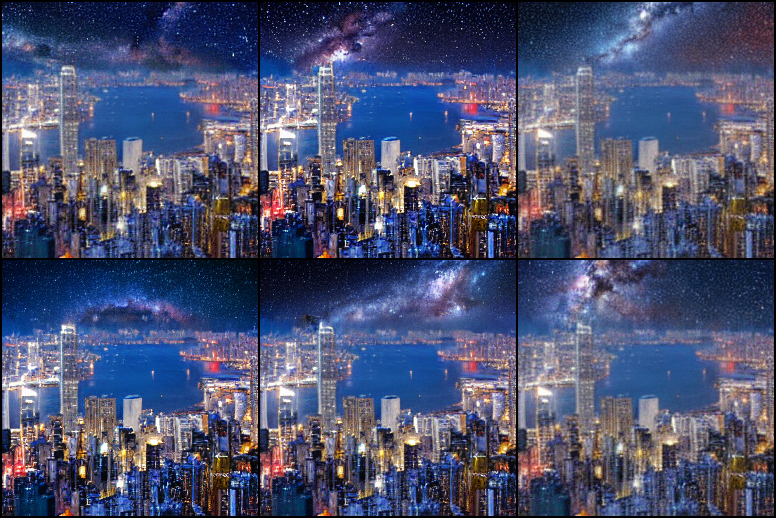

In [ ]:
#@title Parameters
import argparse
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange, repeat
from torchvision.utils import make_grid

Prompt = "Milky way" #@param{type:"string"}
Steps = 50 #@param {type:"integer"}
ETA = 0 #@param{type:"integer"}
Iterations =  2#@param{type:"integer"}
Width=256 #@param{type:"integer"}
Height=256 #@param{type:"integer"}
Samples_in_parallel=3 #@param{type:"integer"}
Diversity_scale=5.0 #@param {type:"number"}
PLMS_sampling=True #@param {type:"boolean"}
nsfw_threshold=100 #@param {type:"number"}  
img_path= "/content/latent-diffusion-inpainting-colab/test/c.jpg" #@param{type:"string"}
mask_path= "/content/latent-diffusion-inpainting-colab/test/c_mask2.jpg" #@param{type:"string"}

args = argparse.Namespace(
    prompt = Prompt, 
    outdir=f'{outputs_path}',
    ddim_steps = Steps,
    ddim_eta = ETA,
    n_iter = Iterations,
    W=Width,
    H=Height,
    n_samples=Samples_in_parallel,
    scale=Diversity_scale,
    plms=PLMS_sampling,
    nsfw_threshold=nsfw_threshold,
    image_prompt=img_path,
    mask_prompt=mask_path
)
run(args)

Using image as x0: /content/latent-diffusion-inpainting-colab/test/c.jpg
Using mask image: /content/latent-diffusion-inpainting-colab/test/c_mask2.jpg


Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


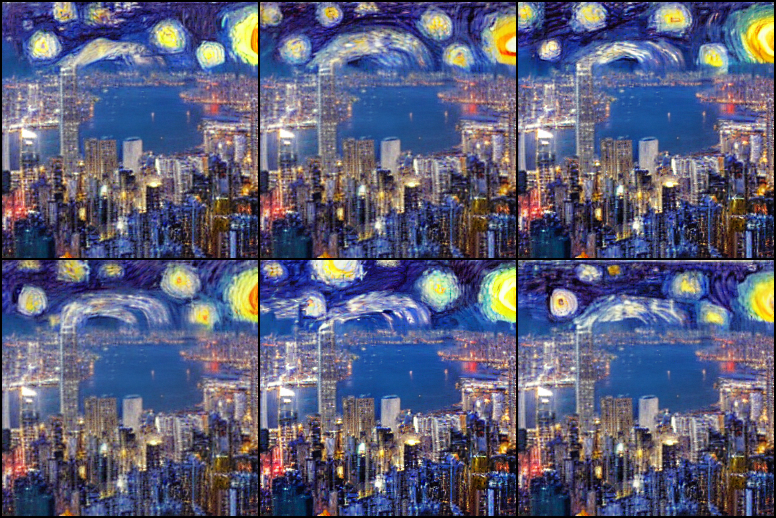

In [ ]:
#@title Parameters
import argparse
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange, repeat
from torchvision.utils import make_grid

Prompt = "Starry night van gogh" #@param{type:"string"}
Steps = 50 #@param {type:"integer"}
ETA = 0 #@param{type:"integer"}
Iterations =  2#@param{type:"integer"}
Width=256 #@param{type:"integer"}
Height=256 #@param{type:"integer"}
Samples_in_parallel=3 #@param{type:"integer"}
Diversity_scale=5.0 #@param {type:"number"}
PLMS_sampling=True #@param {type:"boolean"}
nsfw_threshold=100 #@param {type:"number"}  
img_path= "/content/latent-diffusion-inpainting-colab/test/c.jpg" #@param{type:"string"}
mask_path= "/content/latent-diffusion-inpainting-colab/test/c_mask2.jpg" #@param{type:"string"}

args = argparse.Namespace(
    prompt = Prompt, 
    outdir=f'{outputs_path}',
    ddim_steps = Steps,
    ddim_eta = ETA,
    n_iter = Iterations,
    W=Width,
    H=Height,
    n_samples=Samples_in_parallel,
    scale=Diversity_scale,
    plms=PLMS_sampling,
    nsfw_threshold=nsfw_threshold,
    image_prompt=img_path,
    mask_prompt=mask_path
)
run(args)